In [4]:
! pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [6]:
#this is the path to data C:\Users\HP\Desktop\crypto-classifier\data\processed\crypto_data_labeled.csv
data = pd.read_csv('C:/Users/HP/Desktop/crypto-classifier/data/processed/crypto_data_labeled.csv')

In [7]:
# ststistics summary
data.describe()

,open,high,low,close,volume,quote_asset_volume,num_trades,taker_base_volume,taker_quote_volume,1_day_return,...,rsi,macd,sma20,sma50,sma200,bb_high,bb_low,stochastic_oscillator,future_return,label
count,801.000000,801.000000,801.000000,801.000000,801.000000,8.010000e+02,8.010000e+02,801.000000,8.010000e+02,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,800.000000,801.000000
mean,76703.713820,78077.090811,75287.160537,76775.018090,29754.908627,2.113785e+09,2.907912e+06,14634.371080,1.037162e+09,0.013064,...,55.001032,673.158761,75956.472647,74455.271159,66534.909890,81632.473581,70280.471714,58.696431,0.001748,1.031211
std,27213.797134,27510.102767,26809.318758,27155.119259,19288.838802,1.382692e+09,2.122567e+06,9692.895724,6.900812e+08,0.064383,...,12.658717,1948.087986,27435.066219,27574.292381,25917.919694,28800.551687,26338.939808,27.806927,0.024882,0.572516
min,25840.100000,26397.460000,25764.170000,26221.670000,3282.173520,2.508740e+08,4.217170e+05,1514.419590,1.165812e+08,-0.191150,...,21.527266,-5745.083260,26070.672000,26446.993200,27645.685850,27017.950276,24093.589365,0.451578,-0.085387,0.000000
25%,58974.000000,60234.980000,57610.010000,59013.800000,16694.047740,1.185492e+09,1.404109e+06,8023.906830,5.725864e+08,-0.028136,...,45.644783,-680.956570,59423.283000,59346.392200,43328.607800,64396.169521,53311.935549,35.969439,-0.011199,1.000000
50%,69850.530000,71366.000000,68824.000000,69880.010000,25534.736590,1.773961e+09,2.242529e+06,12539.595340,8.710097e+08,0.008709,...,54.118933,623.209908,68486.363000,66482.243000,63799.523300,73500.810908,63744.018951,62.544587,0.000928,1.000000
75%,102082.830000,104145.760000,99950.770000,102082.830000,37349.447060,2.657406e+09,3.721614e+06,18202.357940,1.305027e+09,0.044710,...,63.305020,1693.728256,100168.608000,98739.504000,90419.132200,107542.913601,93506.060311,83.833875,0.013061,1.000000
max,124658.540000,126199.630000,123084.000000,124658.540000,162065.591860,1.104800e+10,1.201236e+07,77363.263230,5.657171e+09,0.306529,...,87.941054,7019.055192,118285.325500,116632.120400,110444.916800,128011.523790,116672.986260,99.934411,0.118834,2.000000


In [8]:
# check if classes are balanced
data["label"].value_counts()

label
1    538
2    144
0    119
Name: count, dtype: int64

In [9]:
# change datetime to timestamp
data['open_time'] = pd.to_datetime(data['open_time'])
data['close_time'] = pd.to_datetime(data['close_time'])


In [10]:
# check for correlations 
data.corr(numeric_only=True)

,open,high,low,close,volume,quote_asset_volume,num_trades,taker_base_volume,taker_quote_volume,1_day_return,...,rsi,macd,sma20,sma50,sma200,bb_high,bb_low,stochastic_oscillator,future_return,label
open,1.000000,0.998808,0.998303,0.997582,-0.319410,0.202700,0.428485,-0.325142,0.185355,-0.104597,...,-0.137687,0.068233,0.989390,0.968936,0.925861,0.989466,0.979188,-0.113047,-0.090248,-0.080116
high,0.998808,1.000000,0.997873,0.998950,-0.300069,0.224187,0.443207,-0.303919,0.209091,-0.093138,...,-0.127253,0.070755,0.988760,0.968000,0.924389,0.989676,0.977646,-0.100965,-0.091248,-0.081815
low,0.998303,0.997873,1.000000,0.998710,-0.347122,0.170927,0.401697,-0.350420,0.156171,-0.086540,...,-0.119569,0.073066,0.987254,0.966681,0.925443,0.986736,0.977723,-0.091567,-0.089560,-0.081094
close,0.997582,0.998950,0.998710,1.000000,-0.319542,0.201460,0.423182,-0.321904,0.187937,-0.080663,...,-0.113440,0.075008,0.987369,0.966374,0.923837,0.987736,0.976871,-0.082912,-0.093657,-0.083949
volume,-0.319410,-0.300069,-0.347122,-0.319542,1.000000,0.812270,0.425467,0.997087,0.817964,0.112954,...,0.165262,0.177837,-0.330844,-0.356147,-0.395207,-0.303387,-0.357484,0.038871,0.045203,0.053091
quote_asset_volume,0.202700,0.224187,0.170927,0.201460,0.812270,1.000000,0.777580,0.806040,0.996429,0.052348,...,0.068605,0.227184,0.184469,0.146993,0.084700,0.218830,0.145009,-0.024547,-0.007992,0.006509
num_trades,0.428485,0.443207,0.401697,0.423182,0.425467,0.777580,1.000000,0.413223,0.762154,-0.067779,...,-0.083975,0.085083,0.426966,0.404993,0.398519,0.456648,0.390143,-0.137138,-0.011968,0.001760
taker_base_volume,-0.325142,-0.303919,-0.350420,-0.321904,0.997087,0.806040,0.413223,1.000000,0.817797,0.140878,...,0.192864,0.190333,-0.338120,-0.364412,-0.403116,-0.310405,-0.364968,0.068920,0.043491,0.050772
taker_quote_volume,0.185355,0.209091,0.156171,0.187937,0.817964,0.996429,0.762154,0.817797,1.000000,0.084397,...,0.101746,0.242619,0.165299,0.126643,0.065347,0.200150,0.125501,0.009783,-0.007626,0.006203
1_day_return,-0.104597,-0.093138,-0.086540,-0.080663,0.112954,0.052348,-0.067779,0.140878,0.084397,1.000000,...,0.780661,0.467268,-0.207703,-0.233428,-0.205408,-0.186863,-0.228366,0.769531,-0.004453,0.005397


In [11]:
# drop columns that may cause data leakage
data.drop(columns=['future_return','open_time', 'close_time', 'quote_asset_volume'], inplace=True)


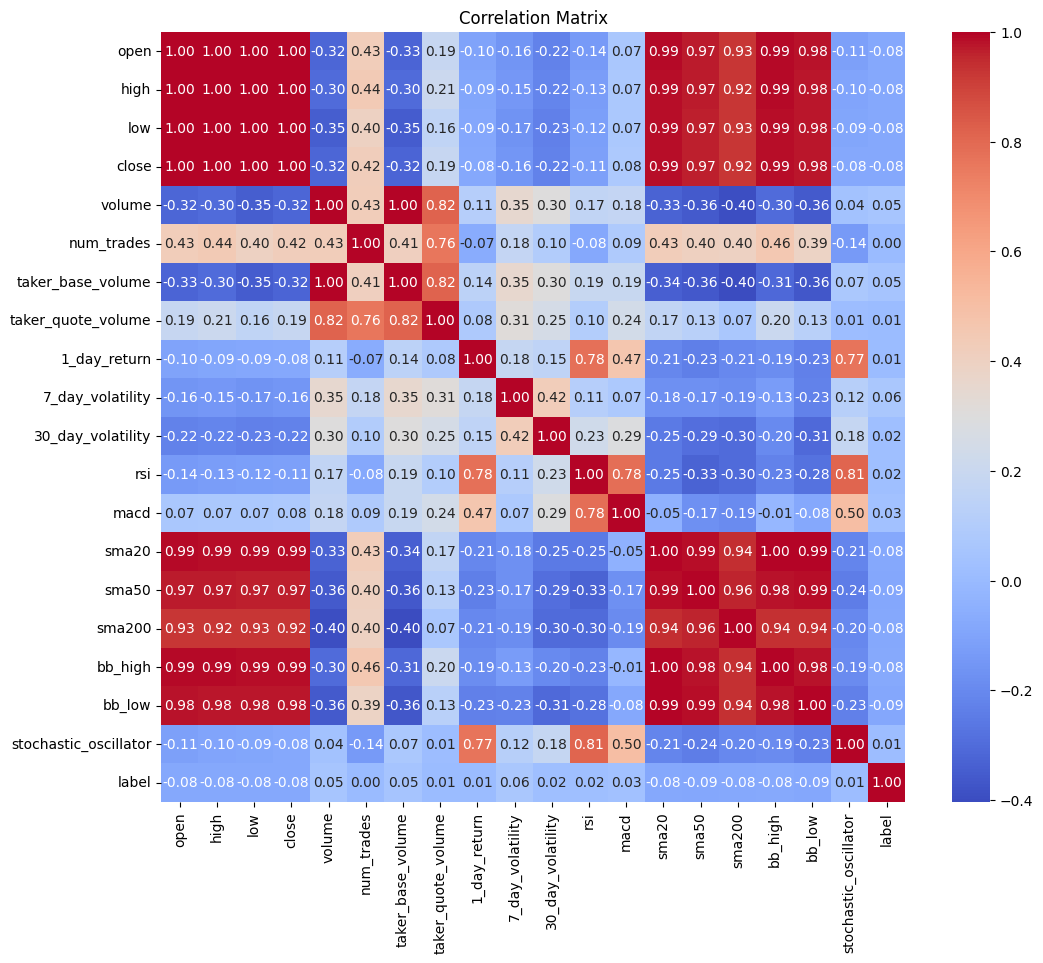

In [12]:
# correlation of numeric columns only
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
# check for multicollinearity using VIF
X = data.select_dtypes(include=['float64', 'int64'])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)


                  feature           VIF
0                    open  1.327026e+04
1                    high  2.056454e+04
2                     low  1.417197e+04
3                   close  1.712002e+04
4                  volume  1.145238e+03
5              num_trades  1.368357e+01
6       taker_base_volume  1.176597e+03
7      taker_quote_volume  8.634793e+01
8            1_day_return  4.560412e+00
9        7_day_volatility  7.904032e+00
10      30_day_volatility  1.784974e+01
11                    rsi  8.208457e+01
12                   macd  4.577720e+01
13                  sma20           inf
14                  sma50  5.794618e+03
15                 sma200  1.298204e+02
16                bb_high           inf
17                 bb_low           inf
18  stochastic_oscillator  2.696158e+01
19                  label  4.282419e+00


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [14]:
# define feature columns and target variables,removing all correlated columns from the heatmap
feature_cols =[ 'close', 'volume','num_trades' ,'1_day_return','7_day_volatility','stochastic_oscillator', 'macd', 'sma20', 'bb_high' ]


# create feature matrix X and target y
X = data[feature_cols]
y = data['label']

In [15]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


In [16]:

# Use: - 70% training - 15% validation - 15% test\
# **No shuffling** because cryptocurrency is time-series.
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
print(f'Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}')



Training set size: (560, 9), Validation set size: (120, 9), Test set size: (121, 9)


In [17]:
# balance the classes 
smote = SMOTE()   # safe for time series because it does NOT shuffle
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
pred_rf = rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.14      0.19      0.16        21
           1       0.76      0.65      0.70        88
           2       0.18      0.25      0.21        12

    accuracy                           0.53       121
   macro avg       0.36      0.36      0.36       121
weighted avg       0.59      0.53      0.56       121



In [19]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_resampled, y_train_resampled)
pred_lgbm = lgbm.predict(X_test)

print("LightGBM:")
print(classification_report(y_test, pred_lgbm))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 1077, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM:
              precision    recall  f1-score   support

           0       0.12      0.14      0.13        21
           1       0.70      0.74      0.72        88
           2       0.25      0.08      0.12        12

    accuracy                           0.57       121
   macro avg       0.36      0.32      0.33       121
weighted avg       0.55      0.57      0.56       121



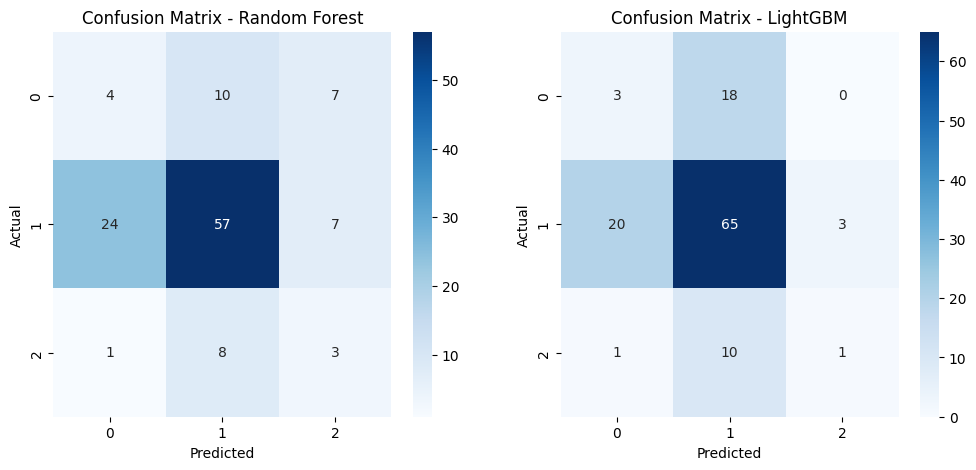

In [24]:
#plot a confusion matrix for all the models
models = {
    "Random Forest": (rf, pred_rf),
    "LightGBM": (lgbm, pred_lgbm)
}

plt.figure(figsize=(12, 5))
for i, (model_name, (model, predictions)) in enumerate(models.items(), 1    ):
    plt.subplot(1, 2, i)
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')    

In [20]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train_resampled, y_train_resampled)
pred_xgb = xgb.predict(X_test)

print("XGBoost:")
print(classification_report(y_test, pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       0.09      0.14      0.11        21
           1       0.69      0.67      0.68        88
           2       0.33      0.08      0.13        12

    accuracy                           0.52       121
   macro avg       0.37      0.30      0.31       121
weighted avg       0.55      0.52      0.53       121



In [21]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(verbose=False)
cat.fit(X_train_resampled, y_train_resampled)
pred_cat = cat.predict(X_test)

print("CatBoost:")
print(classification_report(y_test, pred_cat))


CatBoost:
              precision    recall  f1-score   support

           0       0.14      0.14      0.14        21
           1       0.72      0.78      0.75        88
           2       0.25      0.08      0.12        12

    accuracy                           0.60       121
   macro avg       0.37      0.34      0.34       121
weighted avg       0.57      0.60      0.58       121



In [22]:
# lstm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# reshape input data for LSTM
X_train_lstm = X_train_resampled.values.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1,   X_val.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1,   X_test.shape[1]))
# build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])
# evaluate on test set
y_test_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=-1)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3426 - loss: 1.1037 - val_accuracy: 0.4917 - val_loss: 1.0929
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3556 - loss: 1.0966 - val_accuracy: 0.5500 - val_loss: 1.0908
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3324 - loss: 1.0995 - val_accuracy: 0.1667 - val_loss: 1.0915
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3417 - loss: 1.0978 - val_accuracy: 0.1500 - val_loss: 1.1033
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3445 - loss: 1.0986 - val_accuracy: 0.1667 - val_loss: 1.0980
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3491 - loss: 1.0989 - val_accuracy: 0.1667 - val_loss: 1.1078
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3705 - loss: 1.0958 - val_accuracy: 0.1417 - val_loss: 1.0964
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Test Set Classification Report:
              precision    recall  f1-score   

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificatio